Análisis sinóptico en 850 hPa: flujo de humedad, geopotencial y viento

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np


# Abrimos dataset
sp = xr.open_dataset(r"D:\sinop\nc\sinop1.nc")
sp

Iniciando renderizado de animación...
No se pudo crear MP4 debido a: [WinError 2] El sistema no puede encontrar el archivo especificado
Intentando guardar como GIF (Pillow)...


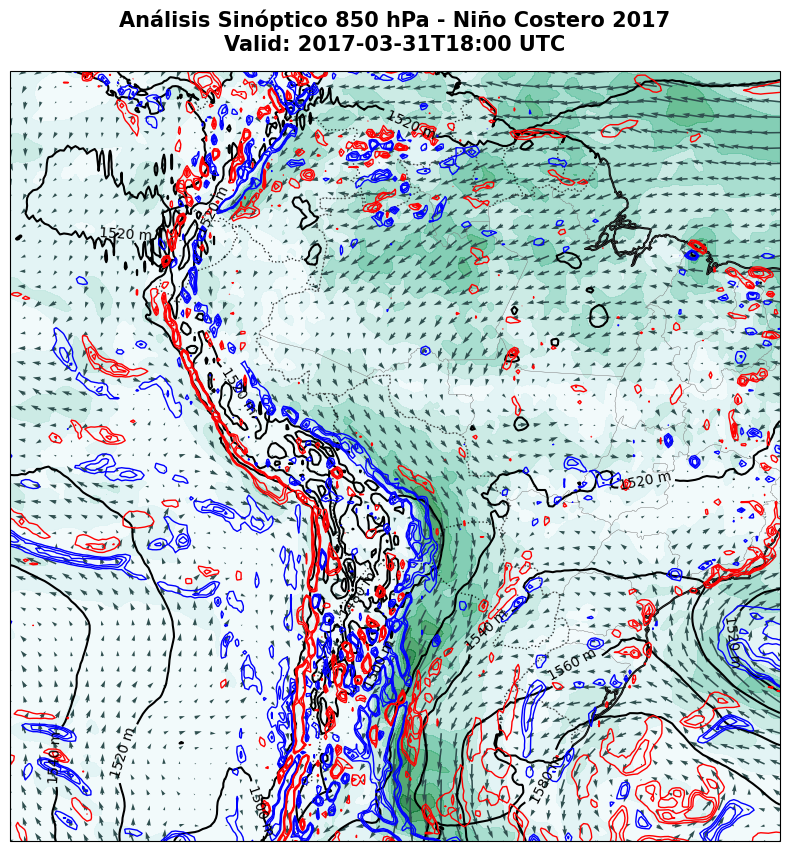

In [18]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.animation as animation
from matplotlib.lines import Line2D
import warnings

warnings.filterwarnings('ignore')

# --- CONFIGURACIÓN DE PARÁMETROS ---
g = 9.80665
nivel = 850
lat_min, lat_max = -40, 10   # Ajustado a Sudamérica tropical/subtropical
lon_min, lon_max = 270, 320  # -90 a -40 (Foco en el Pacífico Este y Perú)

# Cargar datos
ds = xr.open_dataset(r"D:\sinop\nc\sinop1.nc")

# Selección y Cálculo de Variables
ds_sel = ds.sel(
    pressure_level=nivel,
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max)
)

# Variables base
temp = ds_sel['t'] - 273.15
geo  = ds_sel['z'] / g
u    = ds_sel['u']
v    = ds_sel['v']
q    = ds_sel['q']  # Humedad específica en kg/kg
vort = ds_sel['vo']
times = ds_sel['valid_time']

# Variable Avanzada: Flujo de Humedad (Magnitud del vector transporte)
# Multiplicamos el viento por la humedad específica (g/kg)
q_gkg = q * 1000
m_flux = np.sqrt((u * q_gkg)**2 + (v * q_gkg)**2)

# --- CONFIGURACIÓN GRÁFICA ---
fig = plt.figure(figsize=(14, 10))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

def update(i):
    ax.clear()
    
    # Capas base mejoradas
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=1.5, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1, alpha=0.8)
    ax.add_feature(cfeature.STATES, linewidth=0.2, edgecolor='gray')
    
    # 1. Sombreado: Flujo de Humedad (Indica el transporte de agua)
    levels_flux = np.arange(0, 250, 25)
    cf = ax.contourf(q.longitude, q.latitude, m_flux.isel(valid_time=i),
                    levels=levels_flux, cmap='BuGn', alpha=0.8, extend='max')
    
    # 2. Geopotencial: (Líneas negras gruesas)
    geo_levels = np.arange(1200, 1600, 20)
    cs_geo = ax.contour(geo.longitude, geo.latitude, geo.isel(valid_time=i),
                        levels=geo_levels, colors='black', linewidths=1.5)
    ax.clabel(cs_geo, inline=True, fontsize=10, fmt='%d m')

    # 3. Vorticidad: (Rojo: Ciclónica / Azul: Anticiclónica en HS)
    # Nota: En Hemisferio Sur, Vorticidad < 0 es Ciclónica
    vort_levels = np.array([-8, -6, -4, 4, 6, 8]) * 1e-5
    cs_vort = ax.contour(vort.longitude, vort.latitude, vort.isel(valid_time=i),
                         levels=vort_levels, colors=['blue', 'blue', 'blue', 'red', 'red', 'red'],
                         linewidths=1, linestyles='solid')

    # 4. Vectores de Viento
    skip = 4
    qvr = ax.quiver(u.longitude[::skip], u.latitude[::skip], 
                    u.isel(valid_time=i)[::skip, ::skip], 
                    v.isel(valid_time=i)[::skip, ::skip],
                    color='darkslategray', scale=400, width=0.002)
    
    # Títulos y formato
    t_str = str(times.isel(valid_time=i).values)[:16]
    ax.set_title(f"Análisis Sinóptico 850 hPa - Niño Costero 2017\nValid: {t_str} UTC", 
                 fontsize=15, pad=15, fontweight='bold')
    
    return cf,

# --- GUARDADO SEGURO ---
# Intentamos usar FFMpeg explicitamente
try:
    print("Iniciando renderizado de animación...")
    ani = animation.FuncAnimation(fig, update, frames=len(times), interval=300)
    
    # Forzamos el writer para evitar que use Pillow (el causante del error .mp4)
    writer_video = animation.FFMpegWriter(fps=5, bitrate=2000)
    ani.save('analisis_nino_2017.mp4', writer=writer_video)
    print("Éxito: Archivo 'analisis_nino_2017.mp4' creado.")
except Exception as e:
    print(f"No se pudo crear MP4 debido a: {e}")
    print("Intentando guardar como GIF (Pillow)...")
    ani.save('analisis_nino_2017.gif', writer='pillow', fps=5)

plt.show()

ALTURA GEOPOTENCIAL Y FLUJO DE HUMEDAD A 850 hPa

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib import animation
from IPython.display import HTML
import warnings

warnings.filterwarnings('ignore')

# --- IMPORTANTE: Aumentar el límite de memoria para animaciones ---
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128  # Permite animaciones más pesadas

# --- CARGA DE DATOS ---
ds = xr.open_dataset(r"D:\sinop\nc\sinop1.nc")

# Asegúrate de que el nivel y el área estén bien definidos
nivel = 850
ds_sel = ds.sel(pressure_level=nivel, latitude=slice(10, -40), longitude=slice(270, 320))

# Variables
geo = ds_sel['z'] / 9.80665
u, v = ds_sel['u'], ds_sel['v']
q_gkg = ds_sel['q'] * 1000
times = ds_sel['valid_time']
m_flux = np.sqrt((u * q_gkg)**2 + (v * q_gkg)**2)

# --- FIGURA ---
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
levels_flux = np.arange(0, 320, 20)

# Pre-configuramos el colorbar para que no consuma memoria en cada frame
im = ax.contourf(m_flux.longitude, m_flux.latitude, m_flux.isel(valid_time=0), 
                 levels=levels_flux, cmap='YlGnBu', extend='max')
cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.03, shrink=0.8)
cbar.set_label('Flujo de Humedad (g/kg * m/s)')

def update(i):
    ax.clear()
    ax.set_extent([270, 320, -40, 10], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    # Grillas
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.3)
    gl.top_labels = False; gl.right_labels = False

    # Sombreado
    cf = ax.contourf(m_flux.longitude, m_flux.latitude, m_flux.isel(valid_time=i),
                     levels=levels_flux, cmap='YlGnBu', extend='max')

    # Geopotencial
    cs = ax.contour(geo.longitude, geo.latitude, geo.isel(valid_time=i),
                    levels=np.arange(1200, 1600, 20), colors='black', linewidths=1)
    ax.clabel(cs, inline=True, fontsize=8, fmt='%d')

    # Viento (Aumentamos skip para que sea más rápido de procesar)
    skip = 6 
    ax.quiver(u.longitude[::skip], u.latitude[::skip], 
              u.isel(valid_time=i)[::skip, ::skip], v.isel(valid_time=i)[::skip, ::skip],
              color='black', scale=500)

    t_str = str(times.isel(valid_time=i).values)[:16]
    ax.set_title(f"850 hPa | {t_str} UTC", fontsize=11, fontweight='bold')
    return cf,

# --- EJECUCIÓN ---
# Verificamos cuántos frames hay: debería imprimir 68
print(f"Procesando {len(times)} pasos de tiempo...")

ani = animation.FuncAnimation(fig, update, frames=len(times), interval=150)

plt.close()
HTML(ani.to_jshtml())

ALTURA GEOPOTENCIAL (Z) Y VORTICIDAD A 500 hPa

In [ ]:
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128 # Permite ver hasta el día 31

# Selección de datos 500
ds_500 = ds.sel(pressure_level=500, latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
vort_500 = ds_500['vo'] * 1e5 
geo_500 = ds_500['z'] / 9.80665
times = ds_500['valid_time']

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})

def update_500(i):
    ax.clear()
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False; gl.right_labels = False
    
    cf = ax.contourf(vort_500.longitude, vort_500.latitude, vort_500.isel(valid_time=i),
                     levels=np.linspace(-10, 10, 21), cmap='RdBu_r', extend='both')
    
    cs = ax.contour(geo_500.longitude, geo_500.latitude, geo_500.isel(valid_time=i),
                    levels=np.arange(5400, 6000, 20), colors='black', linewidths=1.2)
    ax.clabel(cs, inline=True, fontsize=8, fmt='%d')
    
    skip = 5
    ax.quiver(ds_500.longitude[::skip], ds_500.latitude[::skip], 
              ds_500['u'].isel(valid_time=i)[::skip, ::skip], ds_500['v'].isel(valid_time=i)[::skip, ::skip],
              color='black', scale=500, width=0.002)
    
    ax.set_title(f"500 hPa: Vorticidad y Z | {str(times.isel(valid_time=i).values)[:16]}", fontweight='bold')
    return cf,

im = ax.contourf(vort_500.longitude, vort_500.latitude, vort_500.isel(valid_time=0), levels=np.linspace(-10, 10, 21), cmap='RdBu_r')
fig.colorbar(im, ax=ax, label='Vorticidad ($10^{-5} s^{-1}$)', orientation='horizontal', pad=0.08)
ani500 = animation.FuncAnimation(fig, update_500, frames=len(times), interval=200)
plt.close()
HTML(ani500.to_jshtml())

ALTURA GEOPOTENCIAL (z) Y DIVERGENCIA A 200 hPa

In [ ]:
# Selección de datos 200
ds_200 = ds.sel(pressure_level=200, latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
div_200 = ds_200['d'] * 1e5
geo_200 = ds_200['z'] / 9.80665

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})

def update_200(i):
    ax.clear()
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.3, linestyle='--')
    gl.top_labels = False; gl.right_labels = False
    
    cf = ax.contourf(div_200.longitude, div_200.latitude, div_200.isel(valid_time=i),
                     levels=np.linspace(-6, 6, 21), cmap='PiYG', extend='both')
    
    cs = ax.contour(geo_200.longitude, geo_200.latitude, geo_200.isel(valid_time=i),
                    levels=np.arange(11800, 12600, 40), colors='black', linewidths=1.5)
    ax.clabel(cs, inline=True, fontsize=8, fmt='%d')
    
    skip = 6
    ax.quiver(ds_200.longitude[::skip], ds_200.latitude[::skip], 
              ds_200['u'].isel(valid_time=i)[::skip, ::skip], ds_200['v'].isel(valid_time=i)[::skip, ::skip],
              color='black', scale=800)
    
    ax.set_title(f"200 hPa: Divergencia y Z | {str(times.isel(valid_time=i).values)[:16]}", fontweight='bold')
    return cf,

im = ax.contourf(div_200.longitude, div_200.latitude, div_200.isel(valid_time=0), levels=np.linspace(-6, 6, 21), cmap='PiYG')
fig.colorbar(im, ax=ax, label='Divergencia ($10^{-5} s^{-1}$)', orientation='horizontal', pad=0.08)
ani200 = animation.FuncAnimation(fig, update_200, frames=len(times), interval=200)
plt.close()
HTML(ani200.to_jshtml())

TEMPERATURA SUPERFICIAL DEL MAR, PRESIÓN Y DIRECCIÓN DEL VIENTO

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np


# Abrimos dataset
sfc= xr.open_dataset(r"D:\sinop\nc\data_stream-oper_stepType-instant.nc")
sfc

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np


# Abrimos dataset
x= xr.open_dataset(r"D:\sinop\nc\data_stream-oper_stepType-accum.nc")
x

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib import animation
from IPython.display import HTML
import warnings

warnings.filterwarnings('ignore')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Cargar dataset
sfc= xr.open_dataset(r"D:\sinop\nc\data_stream-oper_stepType-instant.nc")

# Área de enfoque (Pacífico Este y Sudamérica)
lat_min, lat_max = -25, 10
lon_min, lon_max = 270, 315

ds_surf = sfc.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

# Variables
sst = ds_surf['sst'] - 273.15  # Kelvin a Celsius
msl = ds_surf['msl'] / 100     # Pa a hPa
u10, v10 = ds_surf['u10'], ds_surf['v10']
times = sst['valid_time']

# --- CONFIGURACIÓN GRÁFICA ---
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Niveles para SST (Calentamiento costero) y Presión
levels_sst = np.arange(18, 31, 0.5)
levels_msl = np.arange(1006, 1016, 1)

def update_nino(i):
    ax.clear()
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=1.2)
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
    
    # 1. SOMBREADO: Temperatura del Mar (SST)
    cf = ax.contourf(sst.longitude, sst.latitude, sst.isel(valid_time=i),
                     levels=levels_sst, cmap='magma', extend='both')
    
    # 2. CONTORNOS: Presión al nivel del mar (MSL)
    # Las isobaras ayudan a ver dónde se "empaqueta" el aire
    cs = ax.contour(msl.longitude, msl.latitude, msl.isel(valid_time=i),
                    levels=levels_msl, colors='white', linewidths=1, alpha=0.8)
    ax.clabel(cs, inline=True, fontsize=8, fmt='%d hPa')
    
    # 3. VECTORES: Viento a 10m
    skip = 4
    ax.quiver(u10.longitude[::skip], u10.latitude[::skip], 
              u10.isel(valid_time=i)[::skip, ::skip], v10.isel(valid_time=i)[::skip, ::skip],
              color='cyan', scale=150, width=0.002, alpha=0.7)

    t_str = str(times.isel(valid_time=i).values)[:16]
    ax.set_title(f"Niño Costero 2017: SST, Presión y Vientos\nFecha: {t_str} UTC", 
                 fontweight='bold', fontsize=13)
    return cf,

# Colorbar único
im = ax.contourf(sst.longitude, sst.latitude, sst.isel(valid_time=0), levels=levels_sst, cmap='magma')
cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.08, aspect=40)
cbar.set_label('Temperatura Superficial del Mar (°C)')

ani_nino = animation.FuncAnimation(fig, update_nino, frames=len(times), interval=200)
plt.close()
HTML(ani_nino.to_jshtml())

TEMPERATURA DEL MAR, ANTICICLÓN DEL PACÍFICO SUR, ANTICICLÓN DEL ATLÁNTICO SUR Y LLUVIA ACUMULADA

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib import animation
from IPython.display import HTML
import matplotlib

# Configuración de memoria
matplotlib.rcParams['animation.embed_limit'] = 2**128

# --- 1. CARGA Y PREPARACIÓN ---
ds_main = xr.open_dataset(r"D:\sinop\nc\data_stream-oper_stepType-instant.nc")
ds_precip = xr.open_dataset(r"D:\sinop\nc\data_stream-oper_stepType-accum.nc")

# ÁREA SÚPER MACRO: Ampliamos longitud al este para el AAS
lat_lims = slice(15, -60)
lon_lims = slice(220, 350) 

# Selección de datos
ds_sel = ds_main.sel(latitude=lat_lims, longitude=lon_lims)
ds_p_sel = ds_precip.sel(latitude=lat_lims, longitude=lon_lims)

sst = ds_sel['sst'] - 273.15
msl = ds_sel['msl'] / 100
tp = ds_p_sel['tp'] * 1000 
times = sst['valid_time']

# --- 2. CONFIGURACIÓN DE LA FIGURA ---
fig = plt.figure(figsize=(16, 10))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Niveles y Colores
levels_sst = np.arange(4, 32, 1)
levels_msl = np.arange(980, 1032, 4)
levels_tp = [0.5, 2, 5, 15, 30, 60, 100] # Niveles de lluvia más sensibles
colors_tp = ['#00ff00', '#00d9ff', '#007fff', '#0000ff', '#4b0082', '#000000'] # Verde a Negro

def update(i):
    ax.clear()
    ax.set_extent([220, 350, -60, 15], crs=ccrs.PlateCarree())
    
    # Capas Base
    ax.add_feature(cfeature.LAND, facecolor='#d9d9d9', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=1.2, zorder=3)
    ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.4, zorder=3)
    
    # 1. SST (Sombreado Mar)
    cf_sst = ax.contourf(sst.longitude, sst.latitude, sst.isel(valid_time=i),
                         levels=levels_sst, cmap='RdYlBu_r', extend='both', zorder=0)
    
    # 2. LLUVIA (Sombreado resaltado)
    tp_i = tp.isel(valid_time=i)
    if tp_i.max() > 0.1:
        cf_tp = ax.contourf(tp.longitude, tp.latitude, tp_i,
                            levels=levels_tp, colors=colors_tp, alpha=0.8, zorder=2)
    
    # 3. PRESIÓN (Isobáricas)
    cs = ax.contour(msl.longitude, msl.latitude, msl.isel(valid_time=i),
                    levels=levels_msl, colors='black', linewidths=1.2, zorder=4)
    ax.clabel(cs, inline=True, fontsize=10, fmt='%d')

    # Identificación de Sistemas
    ax.text(250, -35, 'APS', fontsize=18, color='darkblue', fontweight='bold', transform=ccrs.PlateCarree(), zorder=5)
    ax.text(330, -30, 'AAS', fontsize=18, color='darkblue', fontweight='bold', transform=ccrs.PlateCarree(), zorder=5)

    t_str = str(times.isel(valid_time=i).values)[:16]
    ax.set_title(f"Sistema Sudamericano: APS, AAS y Niño Costero\nFecha: {t_str} UTC", 
                 fontweight='bold', fontsize=16)
    
    return cf_sst,

# --- 3. BARRAS DE COLORES ---
# Barra SST
im_sst = ax.contourf(sst.longitude, sst.latitude, sst.isel(valid_time=0), levels=levels_sst, cmap='RdYlBu_r')
cbar_sst = fig.colorbar(im_sst, ax=ax, orientation='horizontal', pad=0.08, shrink=0.5)
cbar_sst.set_label('Temperatura del Mar (°C)')

# Barra Lluvia (Ahora vertical para que no se pierda)
im_tp = ax.contourf(tp.longitude, tp.latitude, tp.isel(valid_time=0), levels=levels_tp, colors=colors_tp)
cbar_tp = fig.colorbar(im_tp, ax=ax, orientation='vertical', pad=0.02, shrink=0.7)
cbar_tp.set_label('Lluvia Acumulada (mm)', fontweight='bold')

ani = animation.FuncAnimation(fig, update, frames=len(times), interval=200)
plt.close()
HTML(ani.to_jshtml())

MAPA SINÓPTICO DE SUPERFICIE, PRESIÓN Y VIENTO

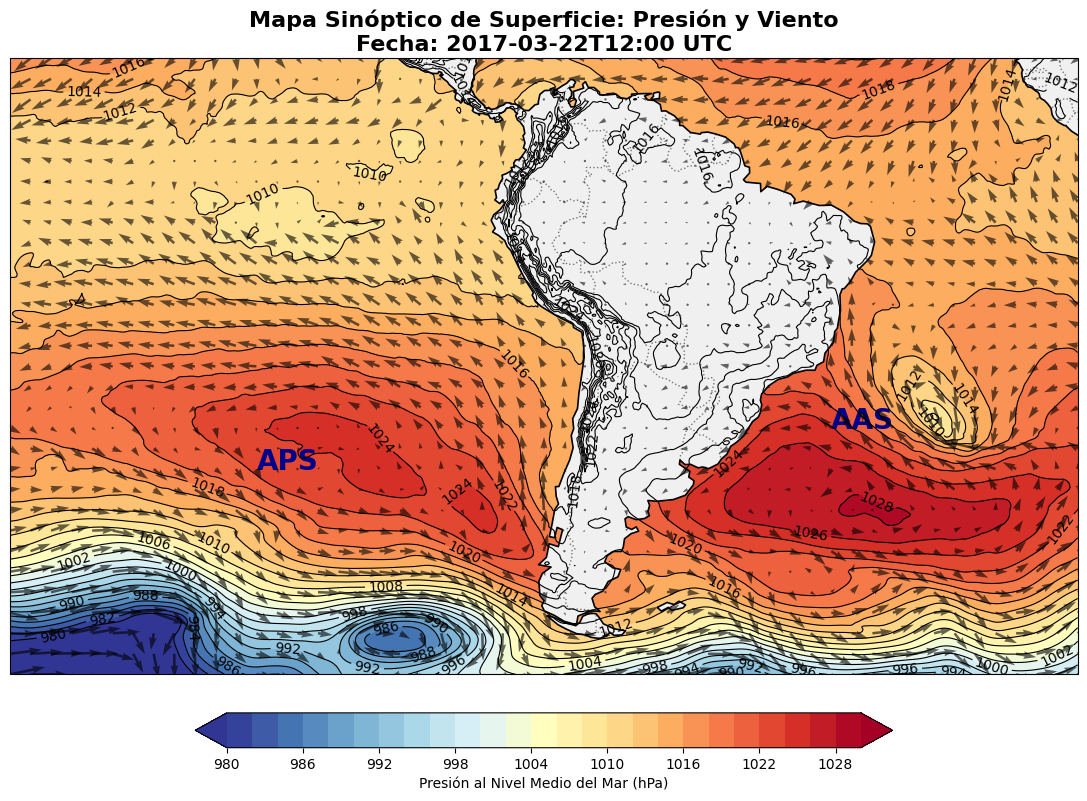

In [42]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# --- 1. CARGA DE DATOS --
ds= xr.open_dataset(r"D:\sinop\nc\data_stream-oper_stepType-instant.nc")

fecha_clave = '2017-03-22T12:00:00'

# Área Macro para ver APS y AAS
lat_lims = slice(15, -60)
lon_lims = slice(220, 350)

# CORRECCIÓN DEL ERROR: Separamos la selección de área y tiempo
ds_area = ds.sel(latitude=lat_lims, longitude=lon_lims)
ds_snap = ds_area.sel(valid_time=fecha_clave, method='nearest')

msl = ds_snap['msl'] / 100  # hPa
u10, v10 = ds_snap['u10'], ds_snap['v10']

# --- 2. GRÁFICO ESTÁTICO ---
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([220, 350, -60, 15], crs=ccrs.PlateCarree())

# Capas de mapa
ax.add_feature(cfeature.LAND, facecolor='#f0f0f0', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=1.2, zorder=3)
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5, zorder=3)

# Sombreado de Presión (Ayuda a ver las masas de aire)
levels_msl = np.arange(980, 1032, 2)
cf = ax.contourf(msl.longitude, msl.latitude, msl, levels=levels_msl, cmap='RdYlBu_r', extend='both', zorder=0)

# Isobáricas (Líneas de presión) - Aquí buscas los frentes
cs = ax.contour(msl.longitude, msl.latitude, msl, levels=levels_msl, colors='black', linewidths=0.8, zorder=4)
ax.clabel(cs, inline=True, fontsize=10, fmt='%d')

# Viento para ver el giro de los Anticiclones
skip = 10
ax.quiver(u10.longitude[::skip], u10.latitude[::skip], u10[::skip, ::skip], v10[::skip, ::skip],
          color='black', scale=500, alpha=0.6, zorder=5)

# Etiquetas de los sistemas
ax.text(250, -35, 'APS', fontsize=20, color='darkblue', fontweight='bold', transform=ccrs.PlateCarree())
ax.text(320, -30, 'AAS', fontsize=20, color='darkblue', fontweight='bold', transform=ccrs.PlateCarree())

# Título con la fecha exacta encontrada
t_real = str(ds_snap.valid_time.values)[:16]
plt.title(f"Mapa Sinóptico de Superficie: Presión y Viento\nFecha: {t_real} UTC", fontweight='bold', fontsize=16)

# Barra de colores
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.05, shrink=0.6)
cbar.set_label('Presión al Nivel Medio del Mar (hPa)')

plt.show()